# MNIST
Just another MNIST

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from keras.layers import BatchNormalization, GlobalAveragePooling2D, concatenate, add
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint, TensorBoard

/home/cahya/.virtualenvs/kaggle/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [38]:
# Define random seed for reproducibility
sns.set(style='white', context='notebook', palette='deep')
random_seed = 1
np.random.seed(random_seed)

# Define the hyperparameters and other variables
epochs = 150 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86
dropout = 0.2
activation = "relu"
verbose = 1
model_file_path = "results/mnist.h5"
model_out = "results/mnist_out.h5"

### Read the MNIST dataset

In [3]:
mnist = pd.read_csv("mnist.csv")

In [4]:
# Build a test dataset of 1000 samples per class
mnist_shuffled = mnist.sample(frac=1, random_state=random_seed).reset_index(drop=True)
class_counter = [0]*10
labels = mnist_shuffled["label"]
images = mnist_shuffled.drop(labels = ["label"],axis = 1)
train_x = []
train_y = []
test_x = []
test_y = []
for i in range(mnist_shuffled.shape[0]):
    label = labels.iloc[i]
    image = images.iloc[i].values
    if class_counter[label]<1000:
        test_x.append(image)
        test_y.append(label)
        class_counter[label] += 1
    else:
        train_x.append(image)
        train_y.append(label)
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)
print(train_x.shape, test_x.shape)

(32000, 784) (10000, 784)


### Show the class distribution of train and test datasets

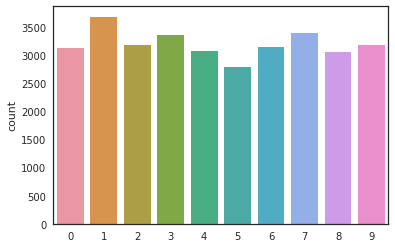

In [5]:
g = sns.countplot(train_y)
#unique, counts = np.unique(train_y, return_counts=True)

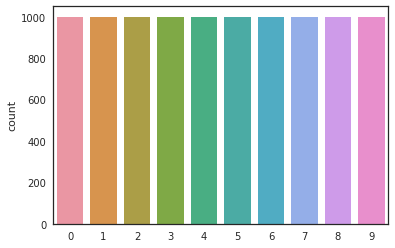

In [6]:
g = sns.countplot(test_y)
#unique, counts = np.unique(test_y, return_counts=True)

### Prepare the datasets

In [7]:
# Normalize the dataset
train_x = train_x / 255.0
test_x = test_x / 255.0

# Reshape the dataset from 1D arrays of 786 pixel to 28x28 array
train_x = train_x.reshape(-1,28,28,1)
test_x = test_x.reshape(-1,28,28,1)

# Convert the labels to one shot vector
train_y = to_categorical(train_y, num_classes = 10)
test_y = to_categorical(test_y, num_classes = 10)

# Split the train dataset in to train and validation datasets
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1, random_state=random_seed)

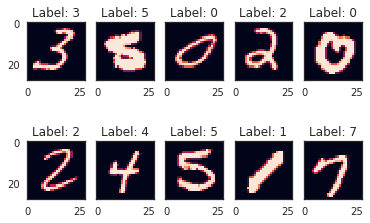

In [8]:
# Display the first 10 samples of train dataset
n = 0
nrows = 2
ncols = 5
fig, ax = plt.subplots(nrows, ncols, sharex=False, sharey=True)
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow((train_x[n]).reshape((28,28)))
        ax[row,col].set_title("Label: {}".format(np.argmax(train_y[n])))
        n += 1

In [9]:
### Create a NN model

def model_create(dropout=0.2, activation='relu'):    
    model = Sequential()
    
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding="same", input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    
    model.add(Conv2D(256, (5, 5), strides=(2, 2), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    
    model.add(Conv2D(256, (1, 1), strides=(1, 1), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    
    model.add(Conv2D(512, (5, 5), strides=(2, 2), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    #model = Model(inputs=[input], outputs=output)
    #optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

    return model

In [10]:
# Function to plot a confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [11]:
# Function to print out the statistic of each class

def class_statistic(confusion_mtx):
    true_positive = np.diag(confusion_mtx)
    false_positive = []
    for i in range(10):
        false_positive.append(np.sum(confusion_mtx[:, i]) - confusion_mtx[i, i])
    false_negative = []
    for i in range(10):
        false_negative.append(np.sum(confusion_mtx[i, :]) - confusion_mtx[i, i])
    true_negative = []
    for i in range(10):
        temp = np.delete(confusion_mtx, i, 0)
        temp = np.delete(temp, i, 1)
        true_negative.append(np.sum(temp))
    error_rate = 1.0 - np.sum(true_positive)/np.sum(confusion_mtx)
    
    true_positive = np.array(true_positive)
    false_positive = np.array(false_positive)
    false_negative = np.array(false_negative)
    true_negative = np.array(true_negative)

    print("True Positive per class:", true_positive)
    print("False Positive per class:", false_positive)
    print("False Negative per class:", false_negative)
    print("True Negative per class:", true_negative)

    true_positive_rate = true_positive / (true_positive + false_negative)
    false_positive_rate = false_positive / (false_positive + true_negative)
    print("True Positive Rate (Recall) per class")
    for i, rate in enumerate(true_positive_rate):
        print("  {}: {:.3f}%".format(i, rate*100))
    print("False Positive Rate per class")
    for i, rate in enumerate(false_positive_rate):
        print("  {}: {:.3f}%".format(i, rate*100))
    print("Error Rate: {:.2f}%".format(error_rate*100))

In [12]:
# Post processing of the prediction
def post_process_prediction(pred_y, test_y):
    pred_true_matrix = np.array(
        [[1.    , 1.    , 0.001 , 1.    , 1.    , 0.04  , 0.02  , 1.    , 0.001 , 0.017 ],
         [1.    , 1.    , 1.    , 1.    , 0.0003, 1.    , 0.9   , 0.00001, 1.   , 0.17  ],
         [1.    , 1.    , 1.    , 0.03  , 1.    , 1.    , 1.    , 0.01    , 0.002 , 0.025 ],
         [1.    , 0.47  , 0.027 , 1.    , 1.    , 0.002 , 1.    , 1.    , 1.    , 0.09  ],
         [1.    , 0.5   , 1.    , 1.    , 1.    , 1.    , 0.0005, 1.    , 0.006 , 0.0002],
         [1.    , 1.    , 1.    , 0.005 , 1.    , 1.    , 1.    , 1.    , 1.    , 0.03  ],
         [0.007 , 0.1   , 1.    , 1.    , 0.001 , 0.0009, 1.    , 1.    , 1.    , 1.    ],
         [1.    , 0.003 , 0.003 , 0.2   , 0.02  , 1.    , 1.    , 1.    , 1.    , 0.0002],
         [0.003 , 1.    , 1.    , 0.0002, 1.    , 0.4   , 0.0001, 0.01  , 1.    , 0.002 ],
         [1.    , 1.    , 1.    , 1.    , 0.05  , 1.    , 1.    , 1.    , 0.008 , 1.    ]])
    
    print(pred_y.shape[0])
    pred_y_good = np.array([])
    pred_y_notsure = np.array([])
    true_y_good = np.array([])
    true_y_notsure = np.array([])

    for i in range(pred_y.shape[0]):
        cls = np.argmax(pred_y[i])
        pred_is_good = True
        for j in range(10):
            if pred_true_matrix[cls, j] == 1.0:
                continue
            if pred_y[i, j]/pred_y[i, cls] >= pred_true_matrix[cls, j]:
                pred_is_good = False
        if pred_is_good:
            pred_y_good = np.append(pred_y_good, cls)
            true_y_good = np.append(true_y_good, np.argmax(test_y[i]))
        else:
            pred_y_notsure = np.append(pred_y_notsure, cls)
            true_y_notsure = np.append(true_y_notsure, np.argmax(test_y[i]))

    print(pred_y_good.shape, pred_y_notsure.shape)
    confusion_mtx = confusion_matrix(true_y_good, pred_y_good)
    # plot the confusion matrix
    plot_confusion_matrix(confusion_mtx, classes = range(10)) 

    confusion_mtx = confusion_matrix(true_y_good, pred_y_good) 
    plot_confusion_matrix(confusion_mtx, classes = range(10)) 

    class_statistic(confusion_mtx)
    print("Coverage: ", 1. - pred_y_notsure.shape[0]/pred_y.shape[0])

In [97]:
# Post processing of the prediction
def post_process_prediction_2(y_pred, y_true):
    threshold_matrix = np.array(
        [[1.    , 0.1   , 0.02  , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 0.006 ],
         [1.    , 1.    , 1.    , 1.    , 0.0005, 0.06  , 0.0008,0.0001 , 1.   , 0.17  ],
         [1.    , 1.    , 1.    , 0.01  , 1.    , 1.    , 1.    , 0.01  , 1.    , 1.    ],
         [1.    , 0.1   , 1.    , 1.    , 1.    , 0.0005, 1.    , 1.    , 1.    , 1.    ],
         [1.    , 0.05  , 1.    , 1.    , 1.    , 1.    , 0.005 , 1.    , 1.    , 0.0003],
         [1.    , 1.    , 1.    , 0.005 , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ],
         [0.008 , 1.    , 1.    , 1.    , 0.004 , 0.003 , 1.    , 1.    , 0.002 , 1.    ],
         [1.    , 0.003 , 0.001 , 1.    , 0.02  , 1.    , 1.    , 1.    , 0.08  , 0.01  ],
         [0.0002, 0.06  , 1.    , 0.004 , 1.    , 0.4   , 0.00001,1.    , 1.    , 0.0003],
         [1.    , 1.    , 0.001 , 0.1   , 0.0004, 0.003 , 1.    , 0.003 , 1.    , 1.    ]])
    
    print(y_pred.shape[0])
    y_pred_good = np.array([])
    y_pred_notsure = np.array([])
    y_true_good = np.array([])
    y_true_notsure = np.array([])

    for i in range(y_pred.shape[0]):
        cls = np.argmax(y_pred[i])
        notsure = np.sum(y_pred[i] > threshold_matrix[cls])
        if notsure >= 1:
            y_pred_notsure = np.append(y_pred_notsure, cls)
            y_true_notsure = np.append(y_true_notsure, np.argmax(y_true[i]))
        else:
            y_pred_good = np.append(y_pred_good, cls)
            y_true_good = np.append(y_true_good, np.argmax(y_true[i]))

    print(y_pred_good.shape, y_pred_notsure.shape)
    confusion_mtx = confusion_matrix(y_true_good, y_pred_good)
    # plot the confusion matrix
    plot_confusion_matrix(confusion_mtx, classes = range(10)) 

    class_statistic(confusion_mtx)
    print("Coverage: ", 1. - y_pred_notsure.shape[0]/y_pred.shape[0])

### Data Augmentation

In [14]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(train_x)

### Train the dataset

In [39]:
tensorboard = TensorBoard(log_dir='graph', histogram_freq=0, write_graph=True, write_images=True)
checkpoint = ModelCheckpoint(model_file_path, monitor='acc', verbose=verbose, 
                             save_best_only=True, mode='max')

# Following callback can be used to reduce learning rate autmotically
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=verbose, 
                                            factor=0.5, 
                                            min_lr=0.00001)

model = model_create(dropout=dropout, activation=activation)
print(model.summary())
history = model.fit_generator(datagen.flow(train_x,train_y, batch_size=batch_size),
                              epochs = epochs, validation_data = (val_x, val_y),
                              verbose = verbose, steps_per_epoch=train_x.shape[0] // batch_size
                              , callbacks=[checkpoint, tensorboard])

print("Max of acc: {}, val_acc: {}".
      format(max(history.history["acc"]), max(history.history["val_acc"])))
print("Min of loss: {}, val_loss: {}".
      format(min(history.history["loss"]), min(history.history["val_loss"])))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_11 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
activation_11 (Activation)   (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_12 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
activation_12 (Activation)   (None, 28, 28, 64)        0         
__________

Epoch 8/150
333/334 [============================>.] - ETA: 0s - loss: 0.0642 - acc: 0.9814
Epoch 00008: acc improved from 0.98043 to 0.98137, saving model to results/mnist.h5
334/334 [==============================] - 23s 69ms/step - loss: 0.0642 - acc: 0.9814 - val_loss: 0.0471 - val_acc: 0.9891
Epoch 9/150
333/334 [============================>.] - ETA: 0s - loss: 0.0599 - acc: 0.9823
Epoch 00009: acc improved from 0.98137 to 0.98238, saving model to results/mnist.h5
334/334 [==============================] - 23s 69ms/step - loss: 0.0598 - acc: 0.9824 - val_loss: 0.0339 - val_acc: 0.9903
Epoch 10/150
333/334 [============================>.] - ETA: 0s - loss: 0.0517 - acc: 0.9841
Epoch 00010: acc improved from 0.98238 to 0.98408, saving model to results/mnist.h5
334/334 [==============================] - 23s 69ms/step - loss: 0.0516 - acc: 0.9841 - val_loss: 0.0359 - val_acc: 0.9900
Epoch 11/150
333/334 [============================>.] - ETA: 0s - loss: 0.0502 - acc: 0.9848
Epoch 000

333/334 [============================>.] - ETA: 0s - loss: 0.0254 - acc: 0.9927
Epoch 00037: acc improved from 0.99220 to 0.99272, saving model to results/mnist.h5
334/334 [==============================] - 23s 69ms/step - loss: 0.0254 - acc: 0.9927 - val_loss: 0.0296 - val_acc: 0.9928
Epoch 38/150
333/334 [============================>.] - ETA: 0s - loss: 0.0263 - acc: 0.9922
Epoch 00038: acc did not improve
334/334 [==============================] - 23s 68ms/step - loss: 0.0262 - acc: 0.9922 - val_loss: 0.0380 - val_acc: 0.9912
Epoch 39/150
333/334 [============================>.] - ETA: 0s - loss: 0.0241 - acc: 0.9929
Epoch 00039: acc improved from 0.99272 to 0.99286, saving model to results/mnist.h5
334/334 [==============================] - 23s 69ms/step - loss: 0.0241 - acc: 0.9929 - val_loss: 0.0350 - val_acc: 0.9912
Epoch 40/150
333/334 [============================>.] - ETA: 0s - loss: 0.0234 - acc: 0.9930
Epoch 00040: acc improved from 0.99286 to 0.99300, saving model to resu

333/334 [============================>.] - ETA: 0s - loss: 0.0183 - acc: 0.9947
Epoch 00068: acc did not improve
334/334 [==============================] - 23s 68ms/step - loss: 0.0183 - acc: 0.9947 - val_loss: 0.0299 - val_acc: 0.9931
Epoch 69/150
333/334 [============================>.] - ETA: 0s - loss: 0.0178 - acc: 0.9947
Epoch 00069: acc did not improve
334/334 [==============================] - 23s 68ms/step - loss: 0.0179 - acc: 0.9946 - val_loss: 0.0311 - val_acc: 0.9928
Epoch 70/150
333/334 [============================>.] - ETA: 0s - loss: 0.0162 - acc: 0.9952
Epoch 00070: acc improved from 0.99471 to 0.99516, saving model to results/mnist.h5
334/334 [==============================] - 23s 69ms/step - loss: 0.0163 - acc: 0.9952 - val_loss: 0.0272 - val_acc: 0.9928
Epoch 71/150
333/334 [============================>.] - ETA: 0s - loss: 0.0160 - acc: 0.9953
Epoch 00071: acc improved from 0.99516 to 0.99533, saving model to results/mnist.h5
334/334 [=============================

333/334 [============================>.] - ETA: 0s - loss: 0.0133 - acc: 0.9962
Epoch 00100: acc did not improve
334/334 [==============================] - 23s 68ms/step - loss: 0.0133 - acc: 0.9962 - val_loss: 0.0254 - val_acc: 0.9953
Epoch 101/150
333/334 [============================>.] - ETA: 0s - loss: 0.0133 - acc: 0.9954
Epoch 00101: acc did not improve
334/334 [==============================] - 23s 68ms/step - loss: 0.0133 - acc: 0.9954 - val_loss: 0.0215 - val_acc: 0.9947
Epoch 102/150
333/334 [============================>.] - ETA: 0s - loss: 0.0154 - acc: 0.9952
Epoch 00102: acc did not improve
334/334 [==============================] - 23s 68ms/step - loss: 0.0154 - acc: 0.9952 - val_loss: 0.0238 - val_acc: 0.9950
Epoch 103/150
333/334 [============================>.] - ETA: 0s - loss: 0.0134 - acc: 0.9962
Epoch 00103: acc did not improve
334/334 [==============================] - 23s 68ms/step - loss: 0.0133 - acc: 0.9962 - val_loss: 0.0253 - val_acc: 0.9941
Epoch 104/150


333/334 [============================>.] - ETA: 0s - loss: 0.0115 - acc: 0.9966
Epoch 00132: acc did not improve
334/334 [==============================] - 23s 68ms/step - loss: 0.0115 - acc: 0.9966 - val_loss: 0.0182 - val_acc: 0.9972
Epoch 133/150
333/334 [============================>.] - ETA: 0s - loss: 0.0103 - acc: 0.9972
Epoch 00133: acc improved from 0.99694 to 0.99718, saving model to results/mnist.h5
334/334 [==============================] - 23s 69ms/step - loss: 0.0103 - acc: 0.9972 - val_loss: 0.0306 - val_acc: 0.9941
Epoch 134/150
333/334 [============================>.] - ETA: 0s - loss: 0.0107 - acc: 0.9967
Epoch 00134: acc did not improve
334/334 [==============================] - 23s 68ms/step - loss: 0.0106 - acc: 0.9967 - val_loss: 0.0224 - val_acc: 0.9959
Epoch 135/150
333/334 [============================>.] - ETA: 0s - loss: 0.0118 - acc: 0.9963
Epoch 00135: acc did not improve
334/334 [==============================] - 23s 68ms/step - loss: 0.0117 - acc: 0.9963 

In [40]:
# Load or save the model
model.save_weights(model_out)
#model.load_weights(model_out)

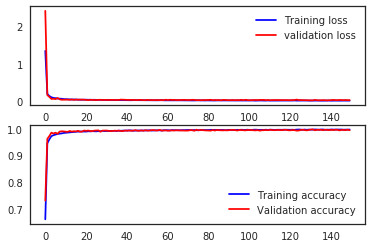

In [41]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

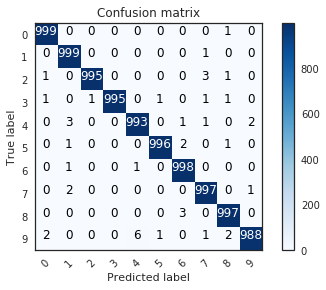

In [64]:
# Predict the values from the validation dataset
test_y_pred = model.predict(test_x)
# Convert one hot vectors to the class number
test_y_pred_class = np.argmax(test_y_pred, axis = 1) 
test_y_true_class = np.argmax(test_y, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(test_y_true_class, test_y_pred_class) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 


In [86]:
for i, cls in enumerate(test_y_pred_class):
    if cls==2 and test_y_true_class[i] != cls:
        print(i)
        print("{} {} {:.7f} {:.7f}".format(cls, test_y_true_class[i], test_y_pred[i, cls], 
                                           test_y_pred[i, test_y_true_class[i]]))


5846
2 3 0.9996160 0.0003160


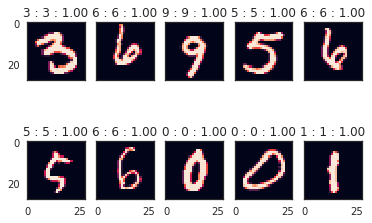

In [51]:
# Predict and show the first 10 samples from test dataset

index = 0
nrows = 2
ncols = 5
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow(test_x[index][:,:,0])
        ax[row,col].set_title("{} : {} : {:.2f}".format((test_y_pred_class[index]), 
                                                        (test_y_true_class[index]), max(test_y_pred[index])))
        index = index+1

True Positive per class: [999 999 995 995 993 996 998 997 997 988]
False Positive per class: [4 7 1 0 7 2 6 7 6 3]
False Negative per class: [ 1  1  5  5  7  4  2  3  3 12]
True Negative per class: [8996 8993 8999 9000 8993 8998 8994 8993 8994 8997]
True Positive Rate (Recall) per class
  0: 99.900%
  1: 99.900%
  2: 99.500%
  3: 99.500%
  4: 99.300%
  5: 99.600%
  6: 99.800%
  7: 99.700%
  8: 99.700%
  9: 98.800%
False Positive Rate per class
  0: 0.044%
  1: 0.078%
  2: 0.011%
  3: 0.000%
  4: 0.078%
  5: 0.022%
  6: 0.067%
  7: 0.078%
  8: 0.067%
  9: 0.033%
Error Rate: 0.43%
10000
(9804,) (196,)
True Positive per class: [998 985 990 986 941 990 996 971 975 962]
False Positive per class: [1 1 1 0 1 1 1 1 1 2]
False Negative per class: [0 0 0 3 3 0 0 0 1 3]
True Negative per class: [8805 8818 8813 8815 8859 8813 8807 8832 8827 8837]
True Positive Rate (Recall) per class
  0: 100.000%
  1: 100.000%
  2: 100.000%
  3: 99.697%
  4: 99.682%
  5: 100.000%
  6: 100.000%
  7: 100.000%
  8: 

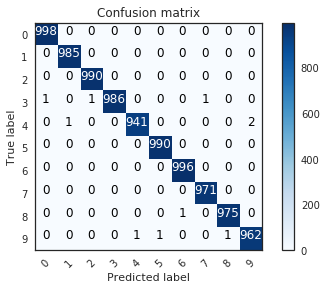

In [98]:
class_statistic(confusion_mtx)
post_process_prediction_2(test_y_pred, test_y)

(60000, 784)
(60000,)
True Positive per class: [5914 6738 5937 6112 5824 5404 5902 6241 5825 5906]
False Positive per class: [14 37  5  8 30 17 23 22 20 21]
False Negative per class: [ 9  4 21 19 18 17 16 24 26 43]
True Negative per class: [54063 53221 54037 53861 54128 54562 54059 53713 54129 54030]
True Positive Rate (Recall) per class
  0: 99.848%
  1: 99.941%
  2: 99.648%
  3: 99.690%
  4: 99.692%
  5: 99.686%
  6: 99.730%
  7: 99.617%
  8: 99.556%
  9: 99.277%
False Positive Rate per class
  0: 0.026%
  1: 0.069%
  2: 0.009%
  3: 0.015%
  4: 0.055%
  5: 0.031%
  6: 0.043%
  7: 0.041%
  8: 0.037%
  9: 0.039%
Error Rate: 0.33%
60000
(58920,) (1080,)
True Positive per class: [5912 6656 5915 6059 5563 5389 5882 6060 5702 5728]
False Positive per class: [7 8 2 6 6 8 5 2 5 5]
False Negative per class: [ 1  0  4  9  3  4  7  4 12 10]
True Negative per class: [53000 52256 52999 52846 53348 53519 53026 52854 53201 53177]
True Positive Rate (Recall) per class
  0: 99.983%
  1: 100.000%
  2:

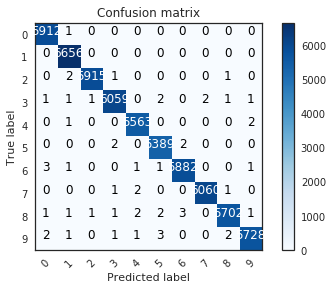

In [99]:
def test_extended():
    mnist_test = pd.read_csv("mnist_train_extended.csv")
    mnist_test_y = mnist_test["label"]
    mnist_test_x = mnist_test.drop(labels = ["label"],axis = 1)
    print(mnist_test_x.shape)
    print(mnist_test_y.shape)

    mnist_test_x = mnist_test_x.values/255.0
    mnist_test_x = mnist_test_x.reshape(-1,28,28,1)
    mnist_test_y = to_categorical(mnist_test_y, num_classes = 10)

    test_x_extended, val_x_extended, test_y_extended, val_y_extended = \
        train_test_split(mnist_test_x, mnist_test_y, test_size=0, random_state=random_seed)
    """
    index = 0
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            ax[row,col].imshow(test_x_extended[index][:,:,0])
            ax[row,col].set_title("{}".format(np.argmax(test_y_extended[index])))
            index = index+1
    """
    # Predict the values from the extended dataset
    pred_y = model.predict(test_x_extended)
    # Convert predictions from one hot vectors to classes
    pred_y_classes = np.argmax(pred_y, axis = 1) 
    # Convert validation observations to one hot vectors
    true_y = np.argmax(test_y_extended, axis = 1) 
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(true_y, pred_y_classes) 
    #print(confusion_mtx)
    # plot the confusion matrix
    # plot_confusion_matrix(confusion_mtx, classes = range(10)) 

    class_statistic(confusion_mtx)
    post_process_prediction_2(pred_y, test_y_extended)
    for n in range(10):
        for i, cls in enumerate(pred_y_classes):
            if cls==n and true_y[i] != cls:
                print("{} {} {:.7f} {:.7f}".format(cls, true_y[i], pred_y[i, cls], pred_y[i, true_y[i]]))

test_extended()

In [34]:
for i, cls in enumerate(test_y_pred_class):
    if cls==7 and test_y_true_class[i] != cls:
        print("{} {} {:.7f} {:.7f}".format(cls, test_y_true[i], test_y_pred[i, cls], test_y_pred[i, test_y_true[i]]))
        #print(cls, true_y[i], pred_y[i], pred_y[i, true_y[i]]/pred_y[i, cls])


NameError: name 'test_y_true' is not defined